In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import imageio
from scipy.io import FortranFile

torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
f = FortranFile('C:/Users/Lawrence Huang/Desktop/Research/z3taured.dat', 'r')
nlos=int(np.asscalar(f.read_ints()))
print("nlos = %d" %nlos)
npix=int(np.asscalar(f.read_ints()))
zred=np.asscalar(f.read_record('f4'))
blenkms=np.asscalar(f.read_record('f4'))
blen=np.asscalar(f.read_record('f4'))*0.001  #back into mpc/h
print(nlos,npix,zred,blenkms,blen)
taured=[]
nstep=128 #skipping through in steps of 64
for i in range(0,nlos,nstep):       
    tauredin=f.read_record('f4')
    taured.extend(tauredin)
f.close()
print('len(taured)=',len(taured))

nlos=int(nlos/nstep)

print ('nlos,npix=',nlos,npix)

taured=np.array(taured)

taured=np.reshape(taured,(nlos,npix))

print('shape of taured=',taured.shape)

print(taured[0,0],taured[0,1])


nlos = 65536
65536 512 3.0 42807.71484375 400.0
len(taured)= 262144
nlos,npix= 512 512
shape of taured= (512, 512)
13.272697 13.76669


15.892097


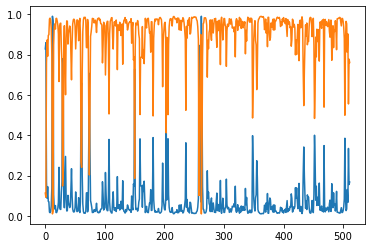

In [3]:
mintaured=taured.min()
maxtaured=taured.max()
taured[taured > 0.5e9] = -1.e10

maxtaured=taured.max()
print (maxtaured)
# set to realistic max:

taured[taured < -0.5e9] = maxtaured
taured=(((taured-mintaured)/(maxtaured-mintaured))*0.98)+0.01
flux=np.exp(-1.*taured)
rmsnoise=0.0 #this is the rms noise to add - if it's zero then we are try 
noise = np.random.normal(0.0,rmsnoise,(nlos,npix))
# 1 is the mean of the normal distribution you are choosing from
# 2 is the standard deviation of the normal distribution
# 3 is the number of elements you get in array noise
flux=flux+noise
minflux=flux.min()
maxflux=flux.max()
flux=(((flux-minflux)/(maxflux-minflux))*0.98)+0.01
taured = torch.from_numpy(taured)
flux = torch.from_numpy(flux)
tauredzero=taured[0,...]

fluxzero=flux[0,...]

#orange is the flux and blue is the optical depth, both scaled to 0.01-0.99
plt.plot(tauredzero.numpy())
plt.plot(fluxzero.numpy())

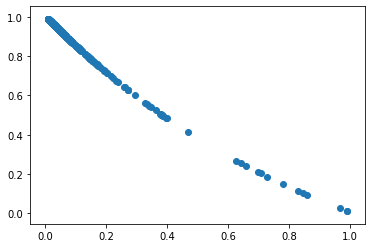

In [4]:
plt.scatter(tauredzero,fluxzero)

In [5]:
a = torch.linspace(0,1,100)
b = torch.tensor([0,10,20,30,40,50,60,70,80,90])

In [6]:
tauredTest = taured[480:,...]
fluxTest = flux[480:,...]
tauredTrain = taured[:480,...]
fluxTrain = flux[:480,...]
print(tauredTest.shape)
print(fluxTest.shape)
print(tauredTrain.shape)
print(fluxTrain.shape)

torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([480, 512])
torch.Size([480, 512])


Prediction:  torch.Size([48, 1, 512])
Epoch =  0
Training Loss =  tensor(0.0163, grad_fn=<MseLossBackward>)
Test Loss =  0.01771309887408279
Prediction:  torch.Size([48, 1, 512])
Epoch =  1
Training Loss =  tensor(0.0174, grad_fn=<MseLossBackward>)
Test Loss =  0.017646707798121497
Prediction:  torch.Size([48, 1, 512])
Epoch =  2
Training Loss =  tensor(0.0169, grad_fn=<MseLossBackward>)
Test Loss =  0.017583856912096962
Prediction:  torch.Size([48, 1, 512])
Epoch =  3
Training Loss =  tensor(0.0175, grad_fn=<MseLossBackward>)
Test Loss =  0.01752246785326861
Prediction:  torch.Size([48, 1, 512])
Epoch =  4
Training Loss =  tensor(0.0155, grad_fn=<MseLossBackward>)
Test Loss =  0.017463814845541492
Prediction:  torch.Size([48, 1, 512])
Epoch =  5
Training Loss =  tensor(0.0170, grad_fn=<MseLossBackward>)
Test Loss =  0.017407113075023517
Prediction:  torch.Size([48, 1, 512])
Epoch =  6
Training Loss =  tensor(0.0177, grad_fn=<MseLossBackward>)
Test Loss =  0.01735139175434597
Predictio

Prediction:  torch.Size([48, 1, 512])
Epoch =  58
Training Loss =  tensor(0.0163, grad_fn=<MseLossBackward>)
Test Loss =  0.01700275149778463
Prediction:  torch.Size([48, 1, 512])
Epoch =  59
Training Loss =  tensor(0.0167, grad_fn=<MseLossBackward>)
Test Loss =  0.017002680950099602
Prediction:  torch.Size([48, 1, 512])
Epoch =  60
Training Loss =  tensor(0.0161, grad_fn=<MseLossBackward>)
Test Loss =  0.017002609936753288
Prediction:  torch.Size([48, 1, 512])
Epoch =  61
Training Loss =  tensor(0.0167, grad_fn=<MseLossBackward>)
Test Loss =  0.017002588778268546
Prediction:  torch.Size([48, 1, 512])
Epoch =  62
Training Loss =  tensor(0.0169, grad_fn=<MseLossBackward>)
Test Loss =  0.017002566979499534
Prediction:  torch.Size([48, 1, 512])
Epoch =  63
Training Loss =  tensor(0.0161, grad_fn=<MseLossBackward>)
Test Loss =  0.017002545413561165
Prediction:  torch.Size([48, 1, 512])
Epoch =  64
Training Loss =  tensor(0.0160, grad_fn=<MseLossBackward>)
Test Loss =  0.017002524313284084


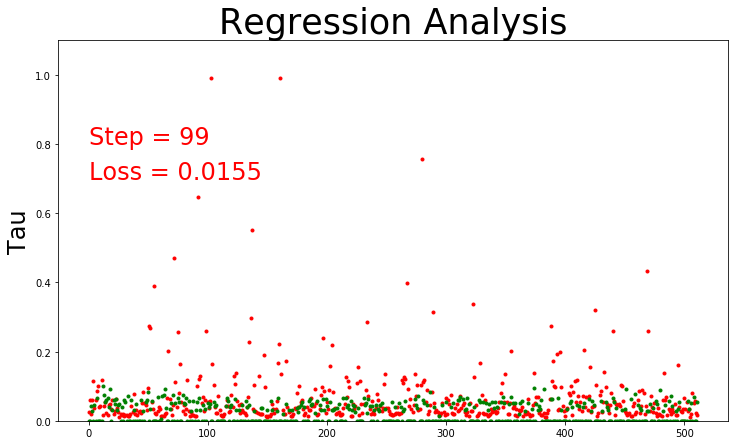

In [14]:
def trainSplit(tauredSet, fluxSet, num):
    indices = torch.randint(low=0,high=tauredSet.shape[0],size=(num,))
#     print(indices)
#     print(tauredSet[indices,...])
#     print(fluxSet[indices,...])
    return tauredSet[indices,...], fluxSet[indices,...]
    

#to test
def validate():
    loss = np.zeros(32)
    net.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i in range(32):
            y = fluxTest[i,...].float()
            y = torch.reshape(y, (-1,1,512))
            y = y.cuda()
            prediction = net(y)
            loss[i] = loss_func(prediction, tauredTest[i,...].float().cuda())
        # print('Test Accuracy of the model on the test data: {} %'.format(100 * correct / total))
    net.train()
    return np.mean(loss)



# this is one way to define a network
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Conv1d(1, 3, 5)   # hidden layer
        self.pool1 = torch.nn.MaxPool1d(5,stride = 1)
        self.hidden2 = torch.nn.Linear(504,1000)
        self.hidden3 = torch.nn.Linear(1000, 1500)
        self.hidden4 = torch.nn.Conv1d(3,1,11)
        self.predict = torch.nn.Linear(1490, 512)   # output layer

    def forward(self, x):
#         IT IS NOT AN ISSUE WITH PASSING THE INFORMATION IN
#         plt.figure()
#         plt.plot(x.reshape(-1).detach())
#         plt.show()
        x = F.relu(self.hidden1(x)) # activation function for hidden layer
#         print(x.shape)
        x = self.pool1(x)
#         print(x.shape)
        x = F.relu(self.hidden2(x))
#         print(x.shape)
        x = F.relu(self.hidden3(x))
#         print(x.shape)
        x = F.relu(self.hidden4(x))
#         print(x.shape)
        x = F.relu(self.predict(x))             # linear output
#         print(x.shape)
        x = x.reshape((-1,1,512))
#         print(x.shape)
#         self.compare(x)
        return x

# net = Net(n_feature=1, n_hidden=10, n_output=1)     # define the network
net = Net()
net = net.cuda()
# print(net)  # net architecture
# optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
optimizer = torch.optim.Adam( net.parameters(), lr=0.00002, weight_decay=0.0005 )
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.3)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
my_images = []
fig, ax = plt.subplots(figsize=(12,7))
totalTrainLoss = torch.zeros(100)
totalTestLoss = torch.zeros(100)
predictedMean = torch.zeros(100)
tauredMean = torch.zeros(100)
a = torch.zeros(512)
a = torch.reshape(a, (-1,1,512))
# train the network
for t in range(100):
    
    x,y = trainSplit(tauredTrain, fluxTrain, 48)
    x = x.float()
    y = y.float()
#     print(x.shape)
#     print(y.shape)
    x = torch.reshape(x, (-1,1,512))
    y = torch.reshape(y, (-1,1,512))
    y = y.cuda()
    x = x.cuda()
    prediction = net(y)     # input x and predict based on x
    print("Prediction: ", prediction.shape)
    if torch.equal(prediction[1], prediction[2]) and torch.equal(prediction[2], prediction[37]):
        print("They're all the same")
    loss = loss_func(prediction, x)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    scheduler.step()        # scheduler decreases learning rate geometrically every n epochs
    
    
    testLoss = validate()
    totalTrainLoss[t] = loss
    totalTestLoss[t] = testLoss
#     predictedMean[t] = prediction.mean()
#     tauredMean[t] = x.mean()
    
    print("Epoch = ", t)
    print("Training Loss = ", loss)
    print("Test Loss = ", testLoss)
#     print(x.shape)
    for k in range(48):
#         print(x.shape)
        s = torch.reshape(x[k], (-1,))
        r = torch.reshape(prediction[k], (-1,))
    # plot and show learning process
        plt.cla()
        ax.set_title('Regression Analysis', fontsize=35)
        ax.set_xlabel('', fontsize=24)
        ax.set_ylabel('Tau', fontsize=24)
        ax.plot(s.data.cpu().numpy(), "r.")
        ax.plot(r.data.cpu().numpy(), 'g.', lw=3)
        ax.text(0.6, 0.8, 'Step = %d' % t, fontdict={'size': 24, 'color':  'red'})
        ax.text(0.6, 0.7, 'Loss = %.4f' % loss.data.cpu().numpy(),
                fontdict={'size': 24, 'color':  'red'})

#         ax.set_xlim(0,1.0)
        ax.set_ylim(0,1.1)

        # Used to return the plot as an image array 
        # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
        fig.canvas.draw()       # draw the canvas, cache the renderer
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    my_images.append(image)
    
   


# save images as a gif    
imageio.mimsave('./taured_prediction.gif', my_images, fps=10)



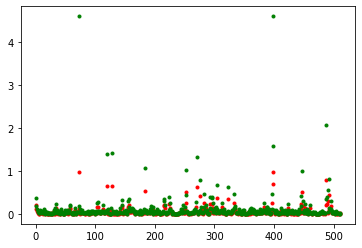

newLoss =  0.053966068
oldLoss =  0.056923393
[[0.06987468 0.08194751 0.02520341 ... 0.04589486 0.09348308 0.15515795]
 [0.37027222 0.19560626 0.11966926 ... 0.02000054 0.03083802 0.02007734]
 [0.06112156 0.10123172 0.07240169 ... 0.27019528 0.10824606 0.06683818]
 ...
 [0.13131852 0.09614718 0.053185   ... 0.1430597  0.20726581 0.05539662]
 [0.04062075 0.03228345 0.02863062 ... 0.20780663 4.6051702  0.08015958]
 [0.01627929 0.01707609 0.0160815  ... 0.02307849 0.02285002 0.02454432]]
tensor([[[0.0112, 0.0165, 0.0000,  ..., 0.0030, 0.0086, 0.0053]],

        [[0.0111, 0.0164, 0.0000,  ..., 0.0025, 0.0087, 0.0056]],

        [[0.0111, 0.0165, 0.0000,  ..., 0.0027, 0.0083, 0.0051]],

        ...,

        [[0.0110, 0.0163, 0.0000,  ..., 0.0029, 0.0084, 0.0052]],

        [[0.0112, 0.0162, 0.0000,  ..., 0.0029, 0.0086, 0.0053]],

        [[0.0113, 0.0165, 0.0000,  ..., 0.0030, 0.0085, 0.0057]]],
       grad_fn=<AsStridedBackward>)


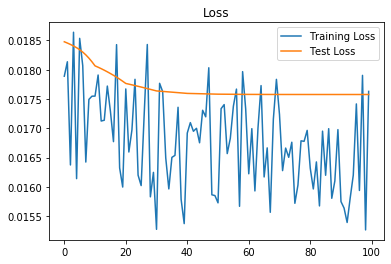

torch.Size([100])
torch.Size([100])


In [12]:
#compare to exponential regression
a = x.view((48,512))
b = y.view((48,512))
c = prediction.view((48,512))
plt.plot(a[1].data.cpu().numpy(), "r.")
expPred = -np.log(b.data.cpu().numpy())
plt.plot(expPred[1], 'g.', lw=3)
plt.show()
newLoss = np.sqrt((a[1].cpu().numpy()-expPred[1])**2).mean()
oldLoss = np.sqrt((a[1].cpu().numpy()-c[1].detach().cpu().numpy())**2).mean()
print("newLoss = ", newLoss)
print("oldLoss = ", oldLoss)
print(expPred)
print(prediction)


plt.show()
plt.figure()
plt.title("Loss")
plt.plot(totalTrainLoss.detach().cpu().numpy(), label="Training Loss")
plt.plot(totalTestLoss.detach().cpu().numpy(), label="Test Loss")
plt.legend()
plt.show()

print(totalTrainLoss.shape)
print(totalTestLoss.shape)


# plt.figure()
# plt.plot(predictedMean.detach())
# plt.plot(tauredMean.detach())
# plt.show()


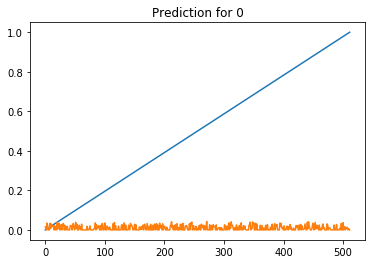

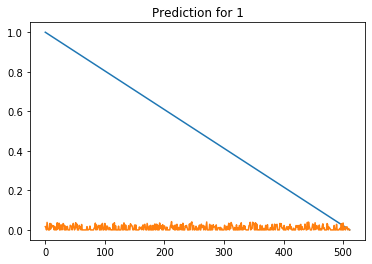

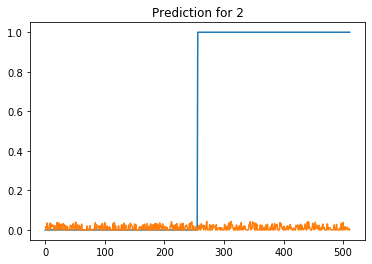

prediction1 equals prediction2:  False
prediction2 equals prediction3:  False
prediction3 equals prediction1:  False
prediction1 - prediction2
tensor([[ 4.9043e-06, -8.8105e-05,  0.0000e+00,  7.5012e-04,  6.1005e-04,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  6.4958e-04, -2.0496e-04,
          4.6644e-04,  4.9584e-04,  2.7745e-04,  1.1143e-04,  2.3659e-04,
          0.0000e+00,  6.8915e-04,  0.0000e+00,  1.1322e-04,  0.0000e+00,
          8.9525e-04,  4.6939e-06,  1.3418e-04,  6.4930e-04,  0.0000e+00,
          0.0000e+00,  3.9247e-04,  2.0735e-04,  0.0000e+00, -5.8319e-05,
          2.6080e-04,  2.7368e-04,  0.0000e+00,  1.2379e-03,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  1.1289e-04,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -6.7428e-04,  1.7795e-04, -9.1131e-04,
          0.0000e+00, -1.3240e-04,  9.7827e-04,  8.4992e-04,  0.0000e+00,
          0.0000e+00,  5.5606e-04,  5.4495e-04,  4.3504e-05,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  3.2350e

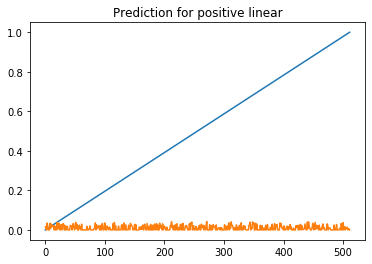

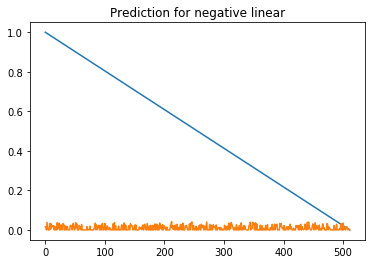

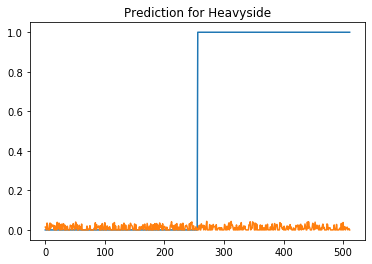

prediction1 equals prediction2:  False
prediction2 equals prediction3:  False
prediction3 equals prediction1:  False
prediction1 - prediction2
tensor([-1.1783e-03, -2.2635e-03,  0.0000e+00, -3.2503e-03,  3.2983e-03,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  9.5420e-04,  3.1618e-03,
        -7.9939e-04,  4.3302e-03,  1.0907e-03,  7.1916e-04,  1.3573e-03,
         0.0000e+00,  2.4833e-03,  0.0000e+00, -1.1472e-04,  0.0000e+00,
         1.2472e-03,  6.3494e-04,  7.4942e-04,  1.0613e-05,  0.0000e+00,
         0.0000e+00, -7.2036e-04,  2.4662e-03,  0.0000e+00, -2.7576e-03,
         3.2715e-04,  6.2237e-04,  0.0000e+00,  9.3235e-04,  0.0000e+00,
         0.0000e+00,  6.6161e-04,  6.3198e-04,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00, -4.4638e-04,  1.7068e-03,  1.7603e-03,
         0.0000e+00,  1.0020e-03, -5.4155e-04,  2.9669e-03,  0.0000e+00,
         2.0292e-03,  1.5402e-03, -3.3839e-03, -9.1316e-04,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  7.3726e-04, -3.6748

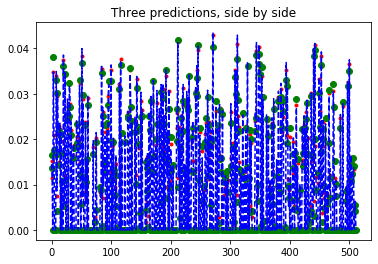

In [13]:
plotY = torch.linspace(0,1,512)
LinearY = torch.reshape(plotY, (-1,1,512))
NegLinearY = 1-1*LinearY
negplotY = 1-1*plotY
heavySidePlot = torch.cat((torch.zeros(256), torch.ones(256)))
HeavySide = torch.reshape(heavySidePlot, (-1,1,512))
net.eval()
with torch.no_grad():
    plots = torch.zeros((3,1,512))
    plots[0,0] = plotY
    plots[1,0] = negplotY
    plots[2,0] = heavySidePlot
    inputs = torch.zeros((3,1,512))
    inputs[0] = LinearY
    inputs[1] = NegLinearY
    inputs[2] = HeavySide
    predictions = net(inputs)
    for j in range(3):
        plot = plots[j]
        forecast = predictions[j]
        plot = plot.reshape(-1)
        forecast = forecast.reshape(-1)
        plt.figure()
        plt.title("Prediction for %d" %j)
        plt.plot(plot.detach().cpu().numpy())
        plt.plot(forecast.detach().cpu().numpy())
        plt.show()
    print("prediction1 equals prediction2: ", torch.equal(prediction[1], prediction[2]))
    print("prediction2 equals prediction3: ", torch.equal(prediction[2], prediction[3]))
    print("prediction3 equals prediction1: ", torch.equal(prediction[3], prediction[1]))
    print("prediction1 - prediction2")
    print(prediction[1]-prediction[2])
    print((((prediction[1]-prediction[2])**2)**.5).mean())

    prediction1 = net(LinearY)
    prediction1 = prediction1.reshape(-1)
    plt.figure()
    plt.title("Prediction for positive linear")
    plt.plot(plotY.detach().cpu().numpy())
    plt.plot(prediction1.detach().cpu().numpy())
    plt.show()

    prediction2 = net(NegLinearY)
    prediction2 = prediction2.reshape(-1)
    plt.figure()
    plt.title("Prediction for negative linear")
    plt.plot(negplotY.detach().cpu().numpy())
    plt.plot(prediction2.detach().cpu().numpy())
    plt.show()

    prediction3 = net(HeavySide)
    prediction3 = prediction3.reshape(-1)
    plt.figure()
    plt.title("Prediction for Heavyside")
    plt.plot(heavySidePlot.detach().cpu().numpy())
    plt.plot(prediction3.detach().cpu().numpy())
    plt.show()
    # print('Test Accuracy of the model on the test data: {} %'.format(100 * correct / total))
net.train()

print("prediction1 equals prediction2: ", torch.equal(prediction1, prediction2))
print("prediction2 equals prediction3: ", torch.equal(prediction2, prediction3))
print("prediction3 equals prediction1: ", torch.equal(prediction3, prediction1))
print("prediction1 - prediction2")
print(prediction1-prediction2)
print((((prediction1-prediction2)**2)**0.5).mean())

plt.figure()
plt.title("Three predictions, side by side")
plt.plot(prediction1.detach().cpu().numpy(), "r.")
plt.plot(prediction2.detach().cpu().numpy(), "go")
plt.plot(prediction3.detach().cpu().numpy(), "b--")